In [1]:
from IMPORTS import *
import pandas as pd
seed_value = 18
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

c:\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and 

In [2]:
word2vec = KeyedVectors.load_word2vec_format('WordEmbeddings/Word2Vec.bin',binary=True)

# ATE

Reading ATE json files

In [3]:
ATE_train = None
ATE_test = None
ATE_val = None
with open("Task1\processed\ATE_train.json") as f1:
    ATE_train  = json.load(f1)

with open("Task1\processed\ATE_test.json") as f2:
    ATE_test = json.load(f2)

with open("Task1\processed\ATE_val.json") as f3:
    ATE_val = json.load(f3)

ATE Dataset

In [4]:
X_train_ate,Y_train_ate= create_train_test_val(ATE_train)
X_test_ate,Y_test_ate = create_train_test_val(ATE_test)
X_val_ate,Y_val_ate = create_train_test_val(ATE_val)

Tokenizing the ATE Dataset

In [5]:
X_train_ate_tokenized, toke = TokenCreator(X_train_ate,1)
X_test_ate_tokenized = TokenCreator(X_test_ate,0,tokenizer = toke)
X_val_ate_tokenized = TokenCreator(X_val_ate,0,tokenizer = toke)

Y_train_ate_tokenized,toke2 = TokenCreator(Y_train_ate,0)
Y_test_ate_tokenized = TokenCreator(Y_test_ate,0,tokenizer = toke2)
Y_val_ate_tokenized = TokenCreator(Y_val_ate,0,tokenizer = toke2)

Vocabulary of ATE

In [6]:
st1 = find_vocab(X_train_ate_tokenized)
vocab_size_ate  = len(st1) + 1 
vocab_size_ate

2406

Padding ATE

In [7]:
X_padded_train = pad_sequences(X_train_ate_tokenized, maxlen=100, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_ate_tokenized, maxlen=100, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_ate_tokenized, maxlen=100, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_ate_tokenized, maxlen=100, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_ate_tokenized, maxlen=100, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_ate_tokenized, maxlen=100, padding="pre", truncating="post")

One hot encoding the ATE labels

In [8]:
Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

Assigning **ATE Word2Vec** mapping

In [9]:
weights_ate_word2vec = np.zeros((vocab_size_ate, 300))

mapping_ate_word2vec = toke.word_index 
mapping_ate_word2vec

{'#UK': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'and': 5,
 'it': 6,
 'to': 7,
 'i': 8,
 'is': 9,
 'a': 10,
 'of': 11,
 'for': 12,
 'with': 13,
 'that': 14,
 'my': 15,
 'you': 16,
 'this': 17,
 'was': 18,
 'in': 19,
 'not': 20,
 'on': 21,
 'very': 22,
 'but': 23,
 'computer': 24,
 'use': 25,
 'have': 26,
 'great': 27,
 'they': 28,
 'laptop': 29,
 "n't": 30,
 'so': 31,
 'has': 32,
 'are': 33,
 'battery': 34,
 'had': 35,
 'screen': 36,
 ')': 37,
 'be': 38,
 'as': 39,
 'all': 40,
 '!': 41,
 '(': 42,
 "'s": 43,
 'also': 44,
 'me': 45,
 'just': 46,
 'easy': 47,
 'when': 48,
 'at': 49,
 'or': 50,
 'only': 51,
 'which': 52,
 'up': 53,
 'life': 54,
 'can': 55,
 'windows': 56,
 'than': 57,
 'out': 58,
 'if': 59,
 'do': 60,
 'after': 61,
 'more': 62,
 'keyboard': 63,
 'would': 64,
 'drive': 65,
 'hard': 66,
 'price': 67,
 'from': 68,
 'well': 69,
 'because': 70,
 'good': 71,
 'one': 72,
 'an': 73,
 'like': 74,
 'mac': 75,
 'about': 76,
 'quality': 77,
 'its': 78,
 'love': 79,
 'get': 80,
 'no': 81,
 'so

Fetching weights from pre trained Word2Vec model (ATE)

In [10]:
for word, index in mapping_ate_word2vec.items():
    if word in word2vec:
        weights_ate_word2vec[index:] = word2vec[word]

Initializing the rnn Model using Word2Vec embeddings

In [11]:
rnn_model_w2v = Sequential()
rnn_model_w2v.add(Embedding(input_dim = vocab_size_ate,output_dim = 300,input_length  = 100,weights = [weights_ate_word2vec],trainable = False))
rnn_model_w2v.add(SimpleRNN(64, return_sequences=True))
rnn_model_w2v.add(TimeDistributed(Dense(Y_padded_train.shape[2], activation='softmax')))

Compiling the rnn Word2Vec Model

In [12]:
rnn_model_w2v.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [13]:
rnn_f1_callback_val = F1ScoreCallback(data=(X_padded_val, Y_padded_val),name='validation')
rnn_f1_callback_train=F1ScoreCallback(data=(X_padded_train, Y_padded_train),name='training')

In [14]:
rnn_model_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          721800    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDist  (None, 100, 4)            260       
 ributed)                                                        
                                                                 
Total params: 745420 (2.84 MB)
Trainable params: 23620 (92.27 KB)
Non-trainable params: 721800 (2.75 MB)
_________________________________________________________________


Fitting the rnn model

In [15]:
rnn_training_w2v = rnn_model_w2v.fit(X_padded_train, Y_padded_train, batch_size=128, epochs=15, validation_data=(X_padded_val, Y_padded_val), callbacks=[rnn_f1_callback_train,rnn_f1_callback_val])

Epoch 1/15




29/29 [==============================] - 0s 8ms/steps: 1.0684 - acc: 0.9240 - precision: 0.9613 - reca
training F1 Score: 0.45792196925505807
7/7 [==============================] - 0s 7ms/step
validation F1 Score: 0.45014560978696144
8/8 [==============================] - 5s 455ms/step - loss: 1.0633 - acc: 0.9242 - precision: 0.9611 - recall: 0.2126 - val_loss: 0.5398 - val_acc: 0.9316 - val_precision: 0.9467 - val_recall: 0.7902
Epoch 2/15
29/29 [==============================] - 0s 7ms/steps: 0.4148 - acc: 0.9346 - precision: 0.9416 - recall
training F1 Score: 0.46108330024152056
7/7 [==============================] - 0s 7ms/step
validation F1 Score: 0.46100300385342535
8/8 [==============================] - 3s 358ms/step - loss: 0.4137 - acc: 0.9347 - precision: 0.9417 - recall: 0.8368 - val_loss: 0.2888 - val_acc: 0.9488 - val_precision: 0.9503 - val_recall: 0.8841
Epoch 3/15
29/29 [==============================] - 0s 11ms/step: 0.2460 - acc: 0.9574 - precision: 0.9572 - re
tra

Testing accuracy

In [16]:
accuracy = rnn_model_w2v.evaluate(X_padded_test, Y_padded_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 0s 8ms/step - loss: 0.0975 - acc: 0.9781 - precision: 0.9801 - recall: 0.9563
0.9781402349472046


Testing F1 Score

In [17]:
Y_pred_ate = rnn_model_w2v.predict(X_padded_test)
real = get_real(Y_padded_test)
pred = get_pred(Y_pred_ate)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("F1 Score:", f1)

11/11 [==============================] - 0s 12ms/step
F1 Score: 0.5581184607640187


Plotting the graph

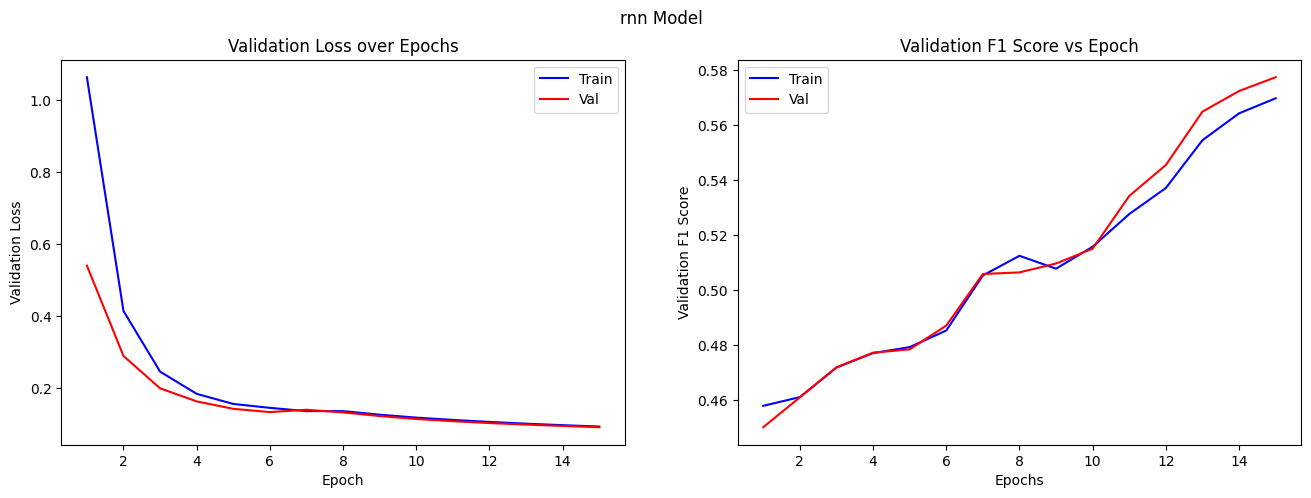

In [18]:
draw_loss_graph(rnn_training_w2v, "rnn Model", rnn_f1_callback_train.f1_scores, rnn_f1_callback_val.f1_scores)
save_model(rnn_model_w2v, "rnn","Word2Vec","t2","ATE")
loaded_model = load_model("Saved_Models/ATE/t2_rnn_Word2Vec.pkl")